In [1]:
username = "Alex"
pathtorepo = "C:\\Users\\" *username *  "\\Desktop\\"
using Pkg
Pkg.activate(pathtorepo * "dynamical-systems\\env\\integrate\\")
include(pathtorepo * "dynamical-systems\\system.jl")
include(pathtorepo * "dynamical-systems\\visual_regimes.jl");

  Activating project at `C:\Users\Alex\Desktop\dynamical-systems\env\integrate`

In [2]:
using StaticArrays, DifferentialEquations, DynamicalSystems, JLD
E, x, y  = -40..40, -5..5,  -5..5
box = E × x × y
using CairoMakie, GLMakie
using LinearAlgebra

In [179]:
function local_min(tr, trange)
    
    localmin = Float64[]
    placeintime = Float64[]
    idxs = Int64[]
    for idx in range(2, length(tr) - 1, step = 1)
        if tr[idx-1] > tr[idx] < tr[idx+1]
            push!(localmin, tr[idx])
            push!(placeintime, trange[idx])
            push!(idxs, idx)
        end
    end
    return localmin, placeintime, idxs
end

function local_max(tr, trange)
    
    localmax= Float64[]
    placeintime = Float64[]
    idxs = Int64[]
    for idx in range(2, length(tr) - 1, step = 1)
        if tr[idx-1] < tr[idx] > tr[idx+1]
            push!(localmax, tr[idx])
            push!(placeintime, trange[idx])
            push!(idxs, idx)
        end
    end
    return localmax, placeintime, idxs
end

function border_burst(lcmin, placeintime, idxs)

    glob_min = Float64[]
    time_glob_min = Float64[]
    idxs_glob_min = Int64[]

    real_glob_min = floor(minimum(lcmin), digits = 2) + 0.5

    for idx in range(2, length(lcmin) - 1, step = 1)
        if lcmin[idx] <= real_glob_min
            push!(glob_min, lcmin[idx])
            push!(time_glob_min, placeintime[idx])
            push!(idxs_glob_min, idxs[idx])
        end
    end
    
    return glob_min, time_glob_min, idxs_glob_min
end

function number_spike_in_burst(data)
    sol, trange = data
    # detect local minimum
    lcmin, place_time, idxs = local_min(sol[:, 1], trange)

    # detect border burst
    glob_min, time_glob_min, idxs_glob_min = border_burst(lcmin, place_time, idxs)

    # check uneven number
    if iseven(length(glob_min)) == false
        deleteat!(glob_min, length(glob_min))
        deleteat!(idxs_glob_min, length(idxs_glob_min))
    end

    number_of_spike = detect_number_spike(glob_min, time_glob_min, idxs_glob_min)

    return number_of_spike
end

function detect_number_spike(glob_min, time_glob_min, idxs_glob_min)


    number_spike = Float64[]
    number_burst = length(glob_min)

    for i in range(1, number_burst-1)
        lcmax, _ = local_max(sol[idxs_glob_min[i]:idxs_glob_min[i+1], 1], trange[idxs_glob_min[i]:idxs_glob_min[i+1]])
        append!(number_spike, length(lcmax))
    end

    maximum(number_spike)

end

detect_number_spike (generic function with 1 method)

In [180]:
cd("C:\\Users\\Alex\\Desktop\\dynamical-systems\\Tsodyks Markram\\Levanova\\3 набор параметров\\Сопоставление с матконт\\файлы matlab")
I0_hom = load("I0_hom_hom.jld")["data"]
u0_hom = load("U0_hom_hom.jld")["data"]
I0_hom = I0_hom[:]
U0_hom = u0_hom[:];

In [181]:
const τ = 0.013;  const τD = 0.07993;  const τy = 3.3;  const J = 3.07;  const β = 0.300
const xthr = 0.75; const ythr = 0.4; const α = 1.58; const ΔU0 = 0.305;

In [182]:
time = 2000; tt = 1000; tstep = 0.001; times = [time, tt]
integ_set = (alg = Vern9(), adaptive = false, dt = tstep);

In [530]:
index_dot = 13 # 25
I0_hom_dot = I0_hom[index_dot]
U0_hom_dot = U0_hom[index_dot]

println("I0: ", I0_hom[index_dot])
println("U0: ", U0_hom[index_dot])

I0: 

-1.7069071372342806
U0: 0.26504556977786675


In [531]:
I0 = I0_hom_dot; U0 = U0_hom_dot
#I0 = -1.7016; U0 = 0.265

p = SA[α, τ, τD, τy, J, xthr, ythr, U0, ΔU0, β, I0]
u0_1 = sol[end] # [13.047572707418132, 0.633500718448283, 0.45016180173293185]
# [8.421422866701183, 0.7359215519694303, 0.43895581827508423]

ds = CoupledODEs(TM, u0_1, p, diffeq = integ_set)

3-dimensional CoupledODEs
 deterministic: true
 discrete time: false
 in-place:      false
 dynamic rule:  TM
 ODE solver:    Vern9
 ODE kwargs:    (adaptive = false, dt = 0.001)
 parameters:    [1.58, 0.013, 0.07993, 3.3, 3.07, 0.75, 0.4, 0.26504556977786675, 0.305, 0.3, -1.7069071372342806]
 time:          0.0
 state:         [11.325905642223786, 0.6594706953104683, 0.4863175026548461]


In [532]:
lyapunovspectrum(ds, 2000, Ttr = 2000)

3-element Vector{Float64}:
  0.46415248146991916
 -0.0022863358574181855
 -4.364671578485084

In [533]:
fp, ei, _ = fixedpoints(ds, box, jacob_TM_);
sol, trange = trajectory(ds, time, Ttr = tt*2, Δt = tstep )

data = [sol, trange]
number_spike_in_burst(data)

75.0

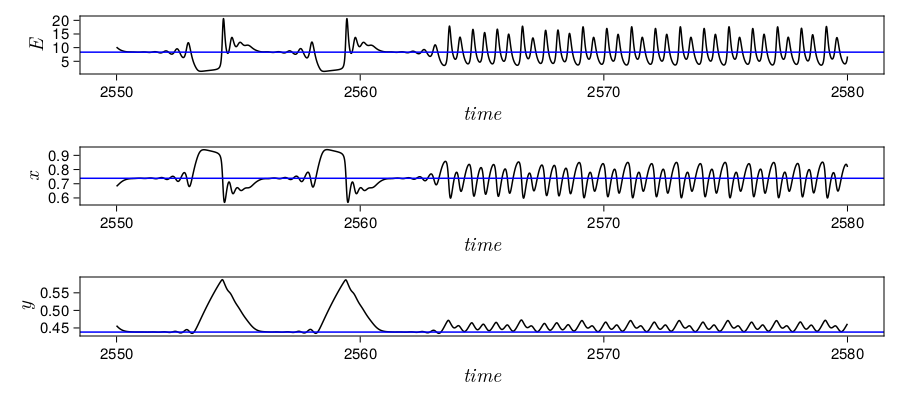

In [534]:
ts, tf = 550000, 580000
lb_size_ts = 20
tck_size_ts = 15
f = Figure(resolution = (900, 400))

axisE = Axis(f[1, 1], xlabel = L"$time$", ylabel = L"$E$",
            xlabelsize = lb_size_ts, ylabelsize = lb_size_ts,
            xticklabelsize = tck_size_ts, yticklabelsize = tck_size_ts,
            xgridvisible = false, ygridvisible = false)
axisx = Axis(f[2, 1], xlabel = L"$time$", ylabel = L"$x$",
            xlabelsize = lb_size_ts, ylabelsize = lb_size_ts,
            xticklabelsize = tck_size_ts, yticklabelsize = tck_size_ts,
            xgridvisible = false, ygridvisible = false)
axisy = Axis(f[3, 1], xlabel = L"$time$", ylabel = L"$y$",
            xlabelsize = lb_size_ts, ylabelsize = lb_size_ts,
            xticklabelsize = tck_size_ts, yticklabelsize = tck_size_ts,
            xgridvisible = false, ygridvisible = false)

lines!(axisE, trange[ts:tf], sol[ts:tf, 1], linewidth = 1.5, color = :black)
hlines!(axisE, fp[1][1], color = :blue)

lines!(axisx, trange[ts:tf], sol[ts:tf, 2], linewidth = 1.5, color = :black)
hlines!(axisx, fp[1][2], color = :blue)

lines!(axisy, trange[ts:tf], sol[ts:tf, 3], linewidth = 1.5, color = :black)
hlines!(axisy, fp[1][3], color = :blue)
#ylims!(axisy, 0.425, 0.48)
f

In [572]:
ts, tf = 1, 700000
idx, idy, idz = 1, 2, 3
lb_size = 30; tck_size = 25;
#dis  = 60;

f = Figure(resolution = (700, 700))
ax = LScene(f[1, 1], show_axis = true)

scale!(ax.scene, 1, 50, 50)

#ax = Axis3(f[1, 1], azimuth = 0.4pi,
            #xlabel = "E", ylabel = "y", zlabel = "x",
            #xlabelsize = lb_size, ylabelsize = lb_size, zlabelsize = lb_size,
            #xticklabelsize = tck_size, yticklabelsize = tck_size, zticklabelsize = tck_size,
            #xgridvisible = false, ygridvisible = false, zgridvisible = false,
            #protrusions = dis, xlabeloffset = dis, ylabeloffset = dis, zlabeloffset = dis)


lines!(sol[ts:tf, idx], sol[ts:tf, idy], sol[ts:tf, idz],
    linewidth = 1.5, color = :deeppink)

for (i, ep) in enumerate(fp)
    scatter!(ep[idx], ep[idy], ep[idz], color = :blue, markersize = 12)
end

display(GLMakie.Screen(), f)

GLMakie.Screen(...)

# Алгоритм вне функций

In [536]:
lcmin, place_time, idxs = local_min(sol[:, 1], trange)

([7.677538950037238, 6.546470238122992, 1.4098723480336122, 7.919407294042762, 10.36679832172439, 10.820365298989339, 8.402271924531963, 8.176956731768367, 7.8744526874310905, 7.0811510509212905  …  5.9593115168738215, 4.2657554320846, 4.052916828608071, 5.131275552897724, 3.3572119046480378, 6.251445667166042, 4.777779420513562, 1.420683017545, 7.91965973568921, 10.36880783968589], [2000.026, 2000.496, 2001.284, 2002.346, 2002.687, 2003.05, 2003.798, 2004.206, 2004.663, 2005.127  …  3994.813, 3995.321, 3995.837, 3996.306, 3996.872, 3997.316, 3997.802, 3998.574, 3999.627, 3999.968], [27, 497, 1285, 2347, 2688, 3051, 3799, 4207, 4664, 5128  …  1994814, 1995322, 1995838, 1996307, 1996873, 1997317, 1997803, 1998575, 1999628, 1999969])

In [537]:
# Border burst
glob_min = Float64[]
time_glob_min = Float64[]
idxs_glob_min = Int64[]

real_glob_min = floor(minimum(lcmin), digits = 2) + 0.5 #2.6

for idx in range(2, length(lcmin) - 1, step = 1)
    if lcmin[idx] <= real_glob_min

        push!(glob_min, lcmin[idx])
        push!(time_glob_min, place_time[idx])
        push!(idxs_glob_min, idxs[idx])
        
    end
end

In [538]:
number_spike = Float64[]

Float64[]

In [539]:
number_burst = length(glob_min)

296

In [540]:
for i in range(1, number_burst-1)
    lcmax, _ = local_max(sol[idxs_glob_min[i]:idxs_glob_min[i+1], 1], trange[idxs_glob_min[i]:idxs_glob_min[i+1]])
    append!(number_spike, length(lcmax))
end

In [541]:
maximum(number_spike)

75.0

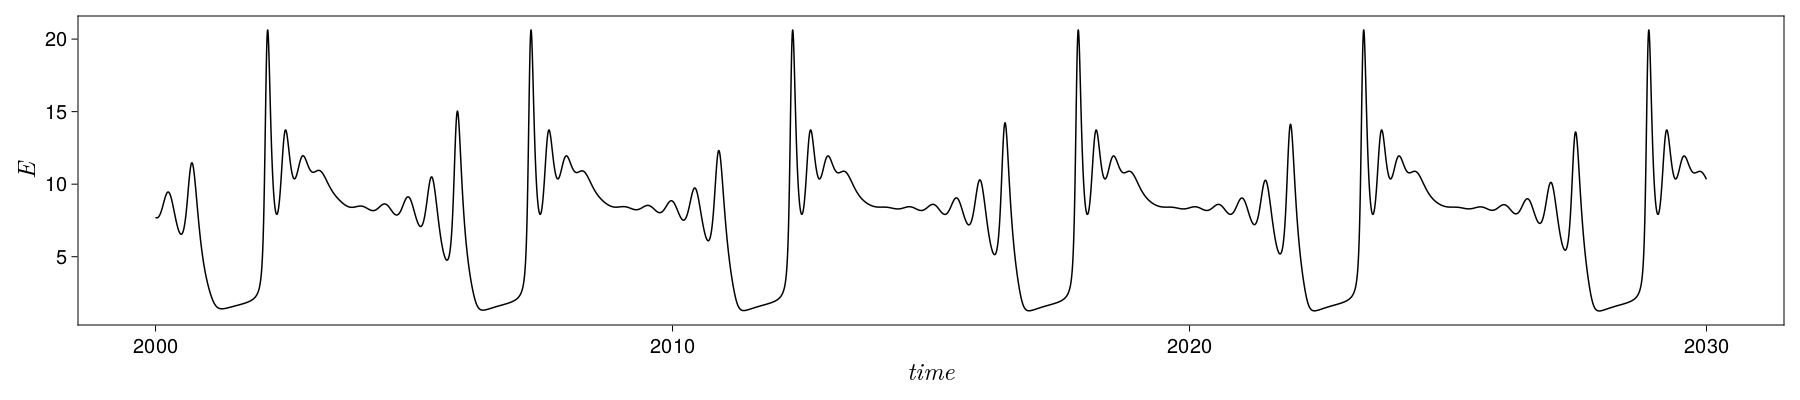

In [553]:
ts, tf = 1, 30000  # idxs_glob_min[idxstart], idxs_glob_min[idxend]

lb_size_ts = 25
tck_size_ts = 20

idxstart, idxend = 1, 377
idxstartbt, idxendbt = 1, 23

f = Figure(resolution = (1800, 400))

axisE = Axis(f[1, 1], xlabel = L"$time$", ylabel = L"$E$",
            xlabelsize = lb_size_ts, ylabelsize = lb_size_ts,
            xticklabelsize = tck_size_ts, yticklabelsize = tck_size_ts,
            xgridvisible = false, ygridvisible = false)

lines!(axisE, trange[ts:tf], sol[ts:tf, 1], linewidth = 1.5, color = :black)

#scatter!(place_time[idxstart:idxend], lcmin[idxstart:idxend], color = :deeppink)

#scatter!(time_glob_min[idxstartbt:idxendbt], glob_min[idxstartbt:idxendbt], color = :lime)

#scatter!(place_time[1009+17], lcmin[1009+17], color = :blue)
#scatter!(place_time[1009+19], lcmin[1009+19], color = :red)
f

In [543]:
abs(lcmin[1009+15] - lcmin[1009+17])

0.7008119523560596

In [544]:
abs(glob_min[1] - glob_min[2])

0.09337484149950592

In [545]:
abs(glob_min[3] - glob_min[4])

0.015066666704942833

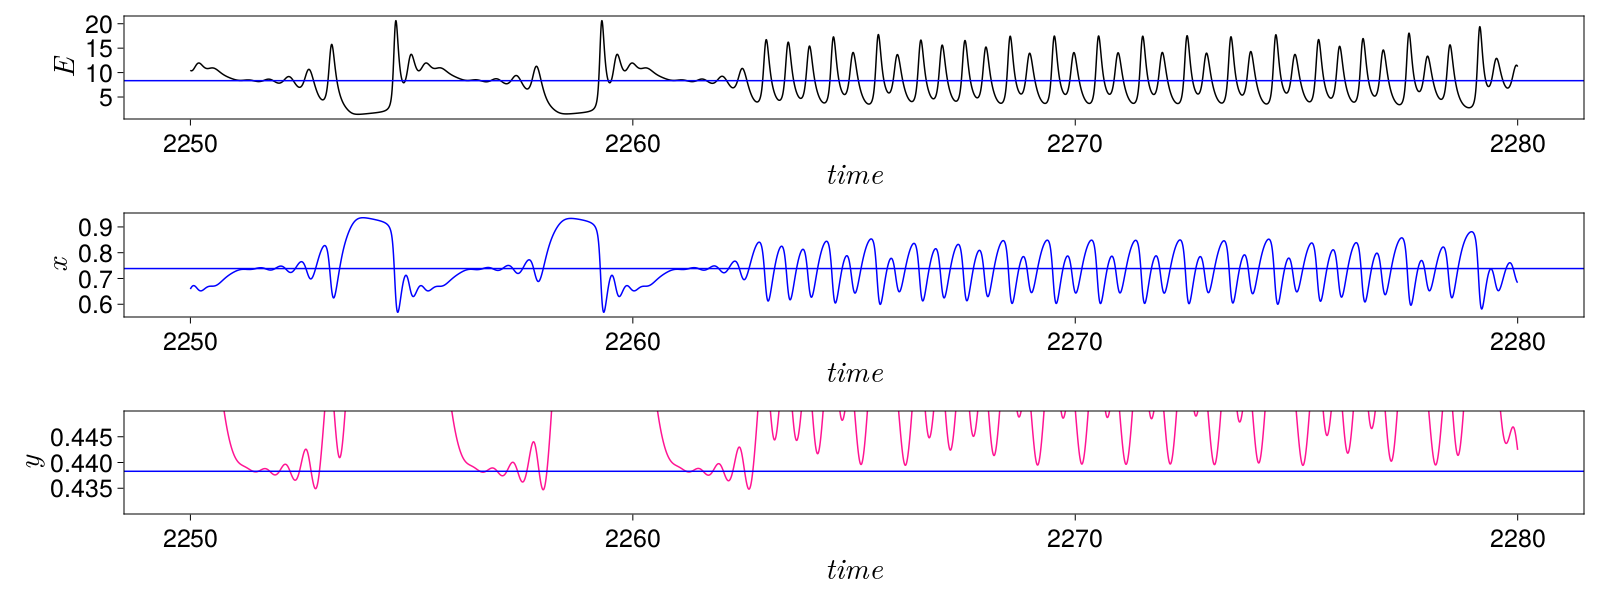

In [551]:
ts, tf = 250000, 280000
lb_size_ts = 30
tck_size_ts = 25
f = Figure(resolution = (1600, 600))

axisE = Axis(f[1, 1], xlabel = L"$time$", ylabel = L"$E$",
            xlabelsize = lb_size_ts, ylabelsize = lb_size_ts,
            xticklabelsize = tck_size_ts, yticklabelsize = tck_size_ts,
            xgridvisible = false, ygridvisible = false)
axisx = Axis(f[2, 1], xlabel = L"$time$", ylabel = L"$x$",
            xlabelsize = lb_size_ts, ylabelsize = lb_size_ts,
            xticklabelsize = tck_size_ts, yticklabelsize = tck_size_ts,
            xgridvisible = false, ygridvisible = false)
axisy = Axis(f[3, 1], xlabel = L"$time$", ylabel = L"$y$",
            xlabelsize = lb_size_ts, ylabelsize = lb_size_ts,
            xticklabelsize = tck_size_ts, yticklabelsize = tck_size_ts,
            xgridvisible = false, ygridvisible = false)


lines!(axisE, trange[ts:tf], sol[ts:tf, 1], linewidth = 1.5, color = :black)
hlines!(axisE, fp[1][1], color = :blue)

lines!(axisx, trange[ts:tf], sol[ts:tf, 2], linewidth = 1.5, color = :blue)
hlines!(axisx, fp[1][2], color = :blue)

lines!(axisy, trange[ts:tf], sol[ts:tf, 3], linewidth = 1.5, color = :deeppink)
hlines!(axisy, fp[1][3], color = :blue)
ylims!(axisy, 0.43, 0.45)
f